MOE

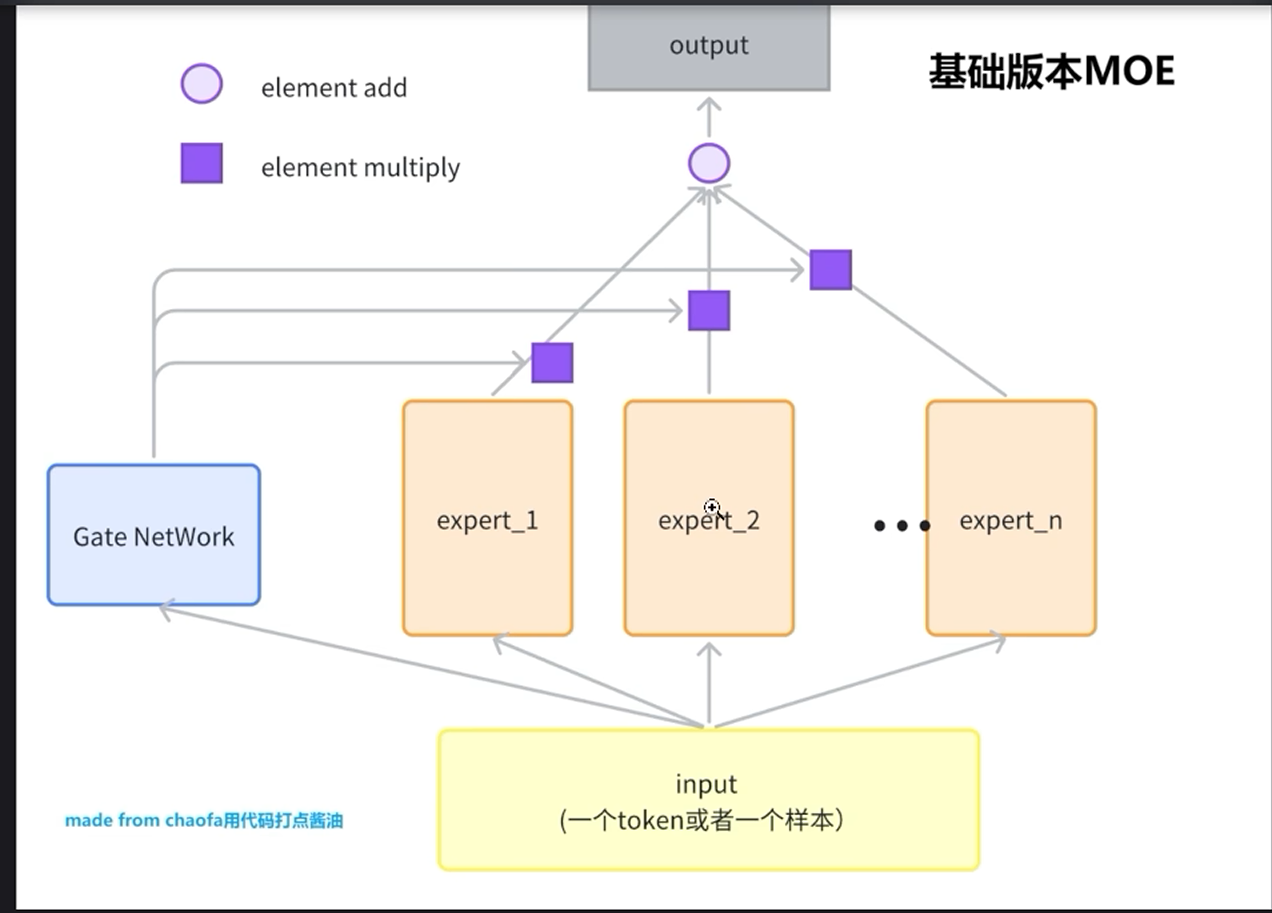

sparse moe 不会激活所有的ffn

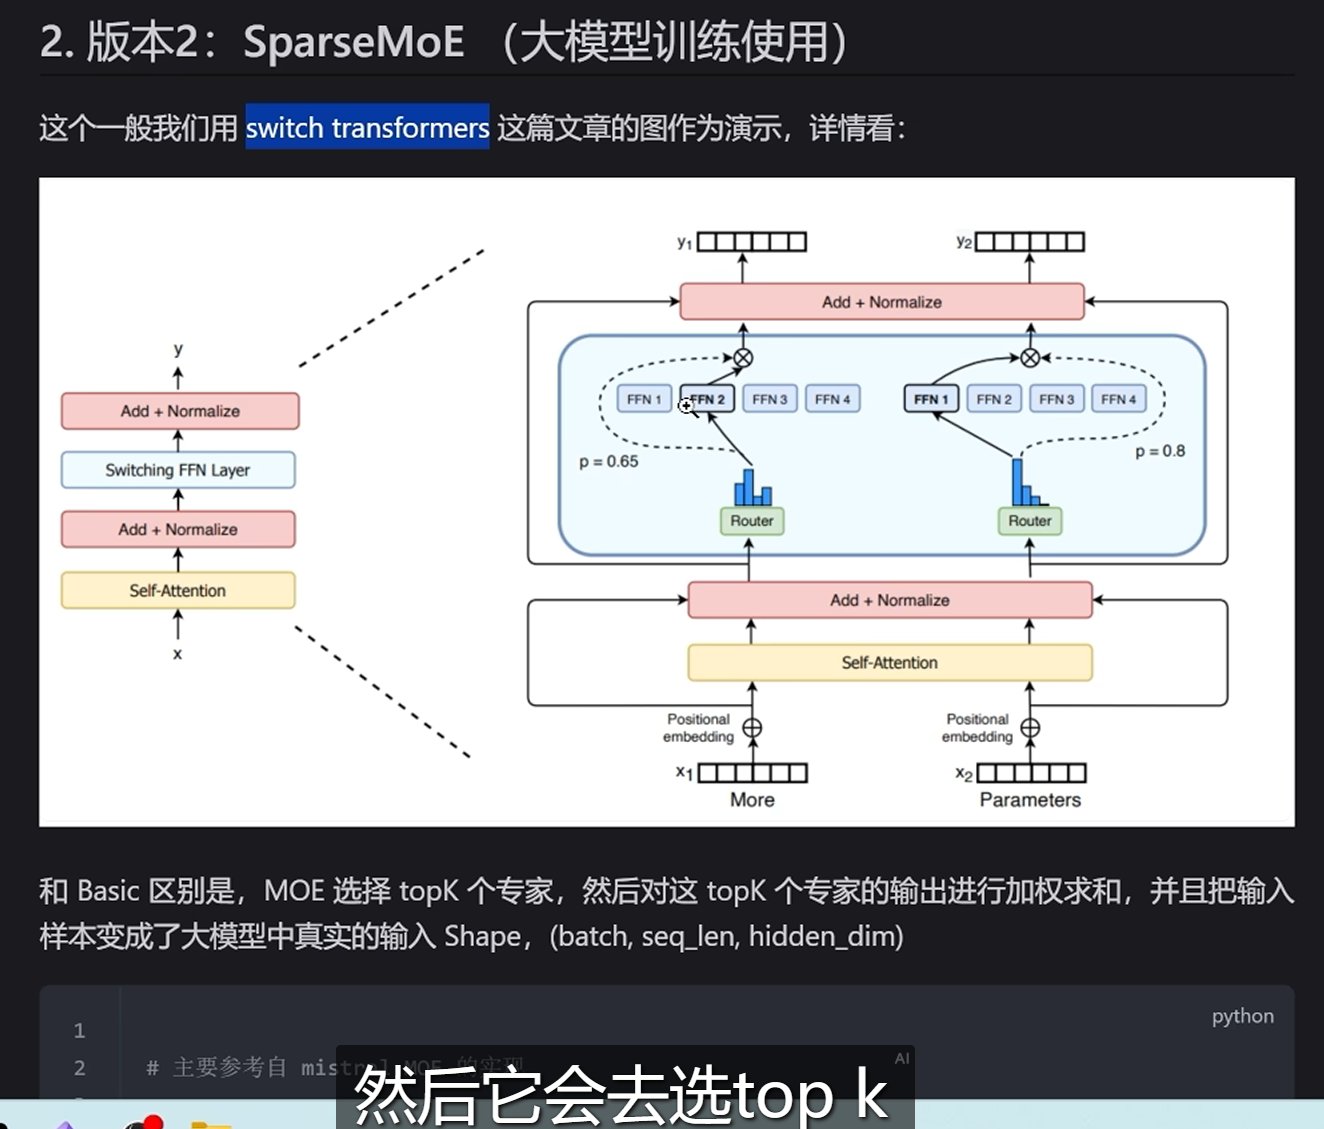

shareexpert sparse moe
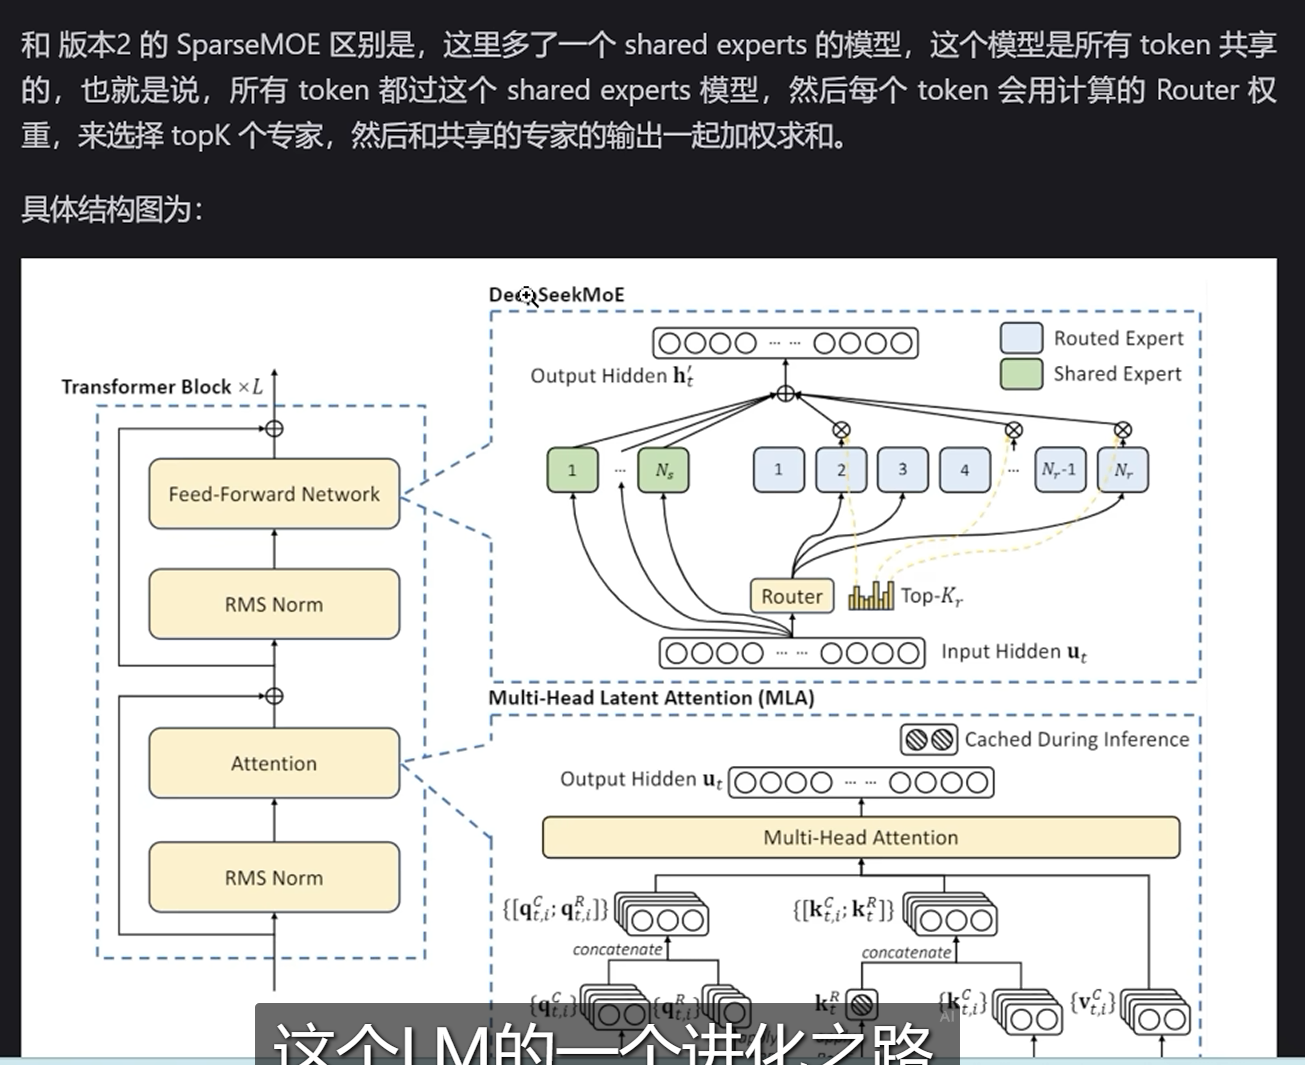


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# MOE

In [2]:
class BasicExpert(nn.Module):
    def __init__(self,feature_in,feature_out):
        super().__init__()
        self.fc = nn.Linear(feature_in, feature_out)

    def forward(self,x):
        return self.fc(x)
    
    

In [4]:
class BasicMOE(nn.Module):
    def __init__(self, feature_in,feature_out,num_expert):
        super().__init__()
        self.gate = nn.Linear(feature_in,num_expert)
        #shape b num_experts
        self.experts = nn.ModuleList(
            BasicExpert(
                feature_in,feature_out
            ) for _ in range(num_expert)
        )
    def forward(self, x): # 512 128
        # x shape is batch feature_in
        # feature_in 也可以叫做hidden_size hidden_dim
        expert_weights = self.gate(x)
        expert_weights = F.softmax(expert_weights, -1)
        expert_out_list = [
            expert(x) for expert in self.experts
        ]# 每一个expert输出一个b feature_out

        # expert_out是b 1 feature_out  # 方便concat
        expert_outputs = [
                expert_out.unsqueeze(1) for expert_out in expert_out_list
            ]
        
        # expert_output  b num_expert feature_out
        expert_output = torch.concat(
            expert_outputs,
            dim=1
        )
        expert_weights = expert_weights.unsqueeze(1)# b 1 num_expert
        # b feature_out期望的输出shape
        output = expert_weights @ expert_output
        return output.squeeze(1)
         

In [7]:
def test_basic_moe():
    x = torch.rand(4, 512) # 没有random
    basic_moe = BasicMOE(512,128,4)
    output = basic_moe(x)
    print(output.shape)

test_basic_moe()
    

torch.Size([4, 128])


# sparseMOE

In [9]:
class MOEConfig:
    def __init__(
        self,
        hidden_dim,
        expert_number,
        top_k,
        shared_experts_number=2
    ):
        self.hidden_dim = hidden_dim
        self.expert_number = expert_number
        self.top_k = top_k
        self.shared_experts_number = shared_experts_number
        

In [10]:
class MOERouter(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.gate = nn.Linear(config.hidden_dim, config.expert_number)
        self.expert_number = config.expert_number
        self.top_k = config.top_k
    def forward(self,x):
        # 假设Expert number是8 topk是2
        router_logits = self.gate(x) # batch*seq_len  expert_number
        # 每个token（batch*seqlen）都有expert_number个专家 # 每个token的topk是不同的！！!!
        # 计算每一个专家的概率
        router_probs = F.softmax(router_logits, dim=1, dtype=torch.float)
        # 计算topk专家的输出 topk是可以反向传播的
        # topk个的权重以及序号
        router_weights, selected_experts_indices = torch.topk(
            router_probs,
            self.top_k,
            dim=-1
        ) 
        # shape都是batch*seq_len, topk
        # 重新做归一化
        router_weights = router_weights/router_weights.sum(dim=-1,keepdim=True)
        router_weights = router_weights.to(x.dtype)
        # 进行onehot处理
        expert_mask = F.one_hot(
            selected_experts_indices,
            num_classes = self.expert_number
        )# b*seq    topk  expert_number
        # expert_numbet topk b*seq
        expert_mask = expert_mask.permute(2,1,0)
        return router_logits, router_weights, selected_experts_indices,expert_mask
        # router_logits      b*seq expert_number
        # router_weights     b*seq topk
        # selected_experts_indices b*seq topk
        # expert_mask              expert_number topk b*seq
        
        

class SparseMOE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # 初始化专家
        self.experts = nn.ModuleList(
            BasicExpert(
                config.hidden_dim,
                config.hidden_dim
            ) for _ in range(config.expert_number)
        )
        self.top_k = config.top_k
        self.hidden_dim = config.hidden_dim
        self.expert_number = config.expert_number
        self.router = MOERouter(config) 

    def forward(self,x):
        batch_size,seq_len, hidden_dim = x.size()
        # b*seq hidden_dim
        hidden_states = x.view(-1,hidden_dim)
        router_logits, router_weights,selected_experts_indices,expert_mask = self.router(hidden_states)

        final_hidden_states = torch.zeros(
            (batch_size*seq_len,hidden_dim),
            dtype = hidden_states.dtype,
            device = hidden_states.device
        )
        # 遍历每一个专家
        # 
        for expert_idx in range(self.expert_number):
            #  expert_masks   expert_number topk  batch*seqlen
            expert_layer = self.experts[expert_idx]
            #  current_expert_mask   shape  topk  batch*seqlen
            # expert_idx在某个token中是top几
            current_expert_mask = expert_mask[expert_idx]
            # top_idx是0或1  假设topk是2
            # 表示这个token是作为当前专家的top1还是top2
            # token_idx 是token再batch*seq中的位置索引
            # 例如对batch_size=2, seq_len=4的输入  
            # token_idx是0-7 表示展平以后8个token的位置
            # top_idx用来选weight
            # token_idx用来选hidden_states（token）
            # 其实这一块主要明白where得到的结果是mask为1的元素的坐标就行了
            top_idx, token_idx = torch.where(current_expert_mask)
            # hidden_states    b*seqlen  hidden_dim
            # current_state (select_token_number hidden_dim)
            current_state = hidden_states.unsqueeze(0)[:,token_idx,:].reshape(-1, hidden_dim)
            current_state = expert_layer(current_state)
            # current_token_router_weight （selected_token_number,1)
            current_token_router_weight = router_weights[token_idx, top_idx].unsqueeze(-1)
            # current_hidden_states （selected_token_number,hidden_dim)
            current_hidden_states = current_state * current_token_router_weight

            final_hidden_states.index_add_(
                0, # 第0维度
                token_idx, # 其中的token_idx
                current_hidden_states.to(hidden_states.dtype) # add上current_hidden_states （selected_token_number,hidden_dim)
            )
        final_hidden_states = final_hidden_states.reshape(batch_size,seq_len,hidden_dim)
        return final_hidden_states, router_logits
            



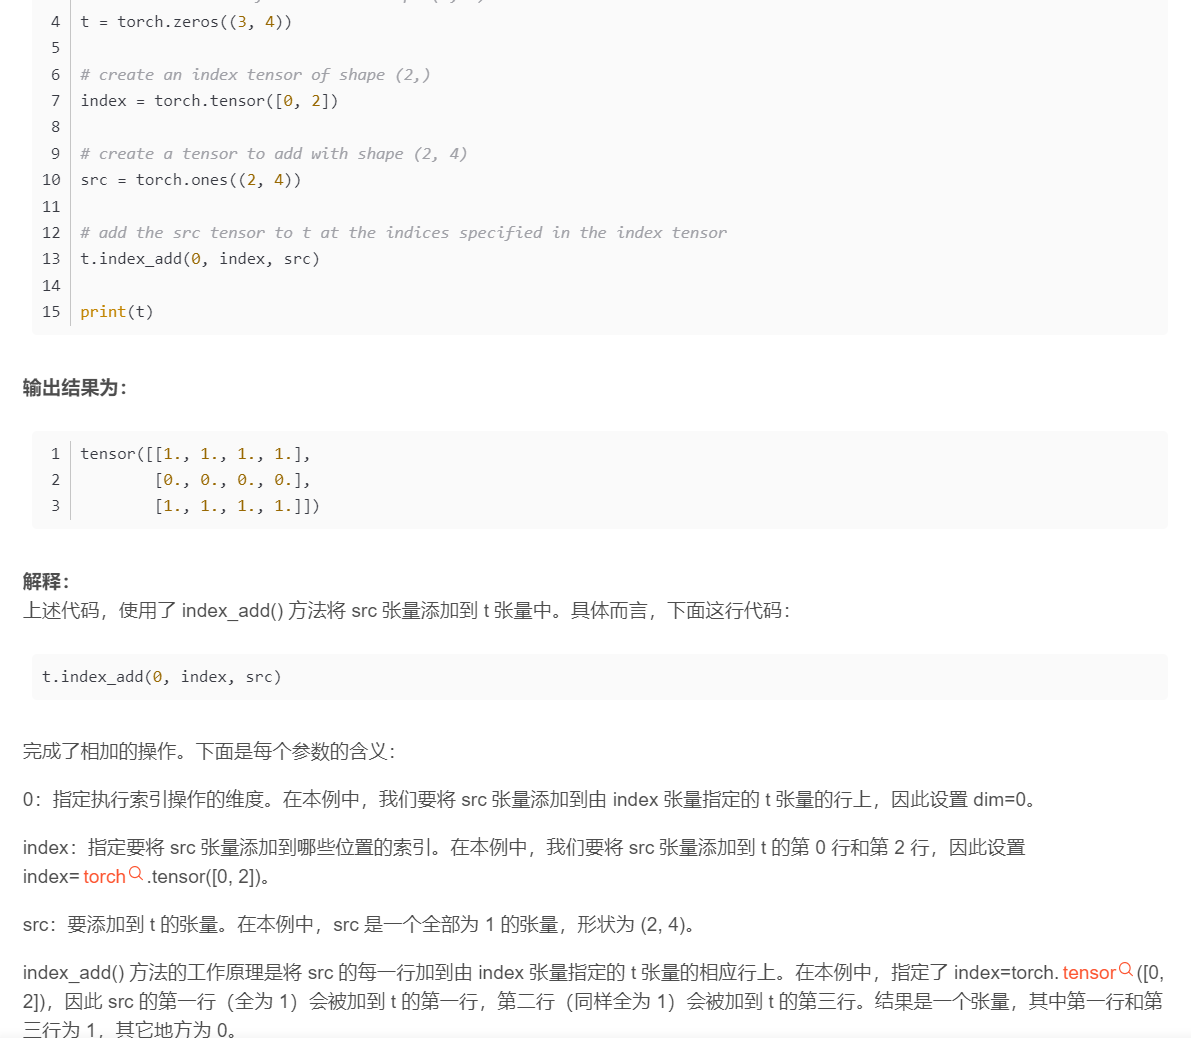

In [14]:
def test_token_level_moe():
    x = torch.rand(2,4,16)
    config = MOEConfig(16,4,2)
    token_level_moe = SparseMOE(config)
    out = token_level_moe(x)
    print(out[0].shape,out[1].shape)

test_token_level_moe()

torch.Size([2, 4, 16]) torch.Size([8, 4])


# ShareExpert SparseMoE(deepseek版本)

In [15]:
class ShareExpertMOE(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.moe_model = SparseMOE(config)
        self.shared_experts = nn.ModuleList(
            [
                BasicExpert(
                    config.hidden_dim, config.hidden_dim
                ) for _ in range(config.shared_experts_number)
            ]
        )

    def forward(self, x):
        # x shape 是 (b, s, hidden_dim)
        # 首先过 moe 模型
        sparse_moe_out, router_logits = self.moe_model(x)
        
        # 针对的还是 x 的每一个 
        # 然后过 shared experts
        shared_experts_out = [
            expert(x) for expert in self.shared_experts
        ] # 每一个 expert 的输出 shape 是 (b, s, hidden_dim)
        # 注意常驻的专家不用门控层算出对应的weight 直接加起来就可以了

        # (shared_experts_number, b, s, hidden_dim)
        # sum以后(b, s, hidden_dim)
        shared_experts_out = torch.stack(
            shared_experts_out, dim=0
        ).sum(dim=0)
        
        # 把 sparse_moe_out 和 shared_experts_out 加起来
        return sparse_moe_out + shared_experts_out, router_logits


def test_share_expert_moe():
    x = torch.rand(2, 4, 16)
    config = MOEConfig(16, 2, 2)
    share_expert_moe = ShareExpertMOE(config)
    out = share_expert_moe(x)
    print(out[0].shape, out[1].shape)


test_share_expert_moe()

torch.Size([2, 4, 16]) torch.Size([8, 2])


In [16]:
def switch_load_balancing_loss(router_logits: torch.Tensor, num_experts: int) -> torch.Tensor:
    """
    计算 Switch Transformers 的负载均衡损失
    
    Args:
        router_logits: shape [batch_size * sequence_length, num_experts]
        num_experts: 专家数量
    
    Returns:
        total_loss: 总损失 = auxiliary_loss + z_loss
    """
    # 计算路由概率
    router_probs = torch.softmax(router_logits, dim=-1)  # [b*s, num_experts]
    
    # 获取每个token的最优专家
    _, selected_experts = torch.topk(router_probs, k=2, dim=-1) 
    
    # 创建one-hot矩阵表示选中的专家
    mask = torch.nn.functional.one_hot(selected_experts, num_experts).float() 
    
    # 计算每个专家的期望负载 (理想情况下应该是 1/num_experts)
    expected_load = torch.ones_like(router_probs) / num_experts
    
    # 计算实际负载 (每个专家处理的token数量除以总token数量)
    # 在batch维度上计算平均值
    actual_load = mask.mean(dim=0)
    
    # 计算auxiliary loss
    # 这会惩罚负载分布与期望负载的差异
    aux_loss = torch.sum(actual_load * router_probs.mean(dim=0)) * num_experts
    
    # 计算z_loss (可选)
    # 这会惩罚过大的路由logits
    z_loss = torch.mean(torch.square(router_logits))
    z_loss_weight = 0.001  # 可调整的超参数
    
    # 总损失
    total_loss = aux_loss + z_loss * z_loss_weight
    
    return total_loss

def test_moe_training():
    # Create a simple dataset
    batch_size = 32
    seq_len = 16
    hidden_dim = 32
    num_batches = 100
    
    # Initialize model and optimizer
    config = MOEConfig(hidden_dim=hidden_dim, 
                      expert_number=4,
                      top_k=2,
                      shared_experts_number=2)
    model = ShareExpertMOE(config)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    model.train()
    for batch in range(num_batches):
        # Generate random input data
        x = torch.randn(batch_size, seq_len, hidden_dim)
        target = torch.randn(batch_size, seq_len, hidden_dim)
        
        # Forward pass
        output, router_logits = model(x)

        # Compute losses
        # MSE loss for prediction
        mse_loss = F.mse_loss(output, target)
        
        aux_loss = switch_load_balancing_loss(router_logits, config.expert_number)
        # Combined loss
        total_loss = mse_loss + 0.01 * aux_loss
        
        # Backward pass and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if batch % 10 == 0:
            print(f"Batch {batch}, Loss: {total_loss.item():.4f} "
                  f"(MSE: {mse_loss.item():.4f}, Aux: {aux_loss.item():.4f})")

# Run the training test
test_moe_training()

Batch 0, Loss: 1.9521 (MSE: 1.9320, Aux: 2.0008)
Batch 10, Loss: 1.7066 (MSE: 1.6866, Aux: 2.0025)
Batch 20, Loss: 1.5888 (MSE: 1.5688, Aux: 2.0010)
Batch 30, Loss: 1.3679 (MSE: 1.3478, Aux: 2.0040)
Batch 40, Loss: 1.3257 (MSE: 1.3056, Aux: 2.0106)
Batch 50, Loss: 1.2592 (MSE: 1.2391, Aux: 2.0048)
Batch 60, Loss: 1.2167 (MSE: 1.1966, Aux: 2.0045)
Batch 70, Loss: 1.1659 (MSE: 1.1459, Aux: 2.0049)
Batch 80, Loss: 1.1526 (MSE: 1.1326, Aux: 2.0080)
Batch 90, Loss: 1.1244 (MSE: 1.1043, Aux: 2.0101)
